In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from numpy import deg2rad, rad2deg
from sklearn.cluster import DBSCAN

In [2]:
def outliers(RA, DEC, Dist, eps, min_samples):
    # Scale RA and DEC for the DBSCAN algorithm to find outliers
    sRA = RA - np.min(RA)
    sDEC = DEC - np.min(DEC)
    sRA = sRA/np.max(sRA)
    sDEC = sDEC/np.max(sDEC)

    # print("Let's detect the outliers!")
    X = np.vstack([sRA, sDEC]).T
    # Do the outlier detection.. parameters carefully chosen
    outlier_detection = DBSCAN(eps=eps, metric='euclidean', min_samples=min_samples, n_jobs=-1)
    clusters = outlier_detection.fit_predict(X)

    # print("Done with outliers")

    IDS_keep = np.where(clusters != -1)
    IDS_rem = np.where(clusters == -1)

    hp.mollview(np.zeros(12), rot=180)
    hp.projscatter(np.pi/2-DEC[IDS_rem], RA[IDS_rem], s=1, c='red')
    hp.projscatter(np.pi/2-DEC[IDS_keep], RA[IDS_keep], s=0.001, c='blue')
    hp.graticule()
    return RA[IDS_keep], DEC[IDS_keep], Dist[IDS_keep]

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


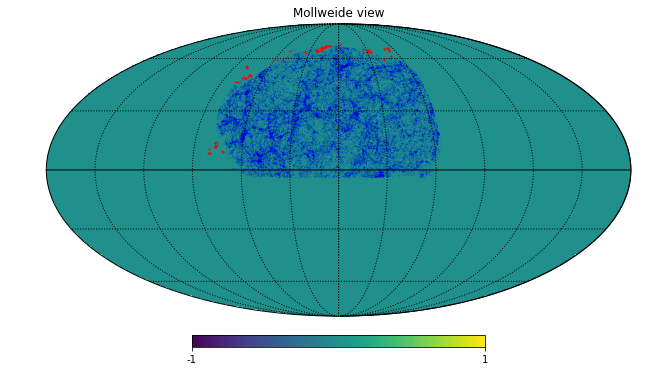

In [3]:
catalog = np.load("../../Data/sdss_cutoff.npy")
RA = np.deg2rad(catalog['ra'])
DEC = np.deg2rad(catalog['dec'])
Dist = catalog['dist']

IDS = np.where(np.logical_and(RA < deg2rad(261), RA > deg2rad(110)))
RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]

IDS = np.where(np.logical_and(RA > deg2rad(250), (np.pi/2-DEC) < deg2rad(35))== False)
RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]

IDS = np.where(np.logical_and(RA > deg2rad(240), (np.pi/2-DEC)>deg2rad(89))==False)
RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]

IDS = np.where((np.pi/2-DEC) < deg2rad(93.5))
RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]

IDS = np.where(np.logical_and(RA < deg2rad(121.5), (np.pi/2-DEC)>deg2rad(90))==False)
RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]

IDS = np.where(np.logical_and(RA < deg2rad(125), (np.pi/2-DEC)<deg2rad(25))==False)
RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]

IDS = np.where((np.pi/2-DEC) > deg2rad(20))
RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]

IDS = np.where(np.logical_and(RA < deg2rad(125), (np.pi/2-DEC)<deg2rad(25))==False)
RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]

nside = 9
pixs_remove = [457, 104, 103, 76, 53, 34, 47, 30]
IDS = list()
for r, d, i in zip(RA, DEC, np.arange(RA.size)):
    pix = hp.ang2pix(nside, np.pi/2-d, r)
    if not pix in pixs_remove:
        IDS.append(i)

RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]

IDS = np.where(RA > deg2rad(116))
RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]


# At this point start performing brutal cuts

# IDS = np.where((np.pi/2-DEC) < deg2rad(92.5))
# RA = RA[IDS]
# DEC = DEC[IDS]

# IDS = np.where(RA > deg2rad(116))
# RA = RA[IDS]
# DEC = DEC[IDS]

nside = 16
pixs_remove = [1293, 1229]
IDS = list()
for r, d, i in zip(RA, DEC, np.arange(RA.size)):
    pix = hp.ang2pix(nside, np.pi/2-d, r)
    if not pix in pixs_remove:
        IDS.append(i)

RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]

RA, DEC, Dist = outliers(RA, DEC, Dist, 0.015, 8)

1229
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


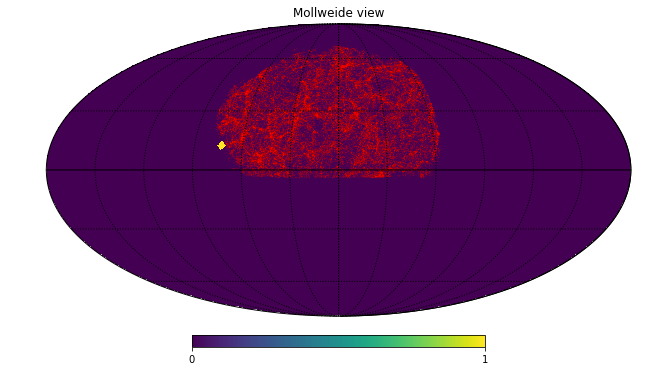

In [4]:
nside = 16
def ang2pix(theta, phi):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    return hp.ang2pix(nside, theta=theta, phi = phi)

px = ang2pix(78, 255)
print(px)

m = np.zeros(hp.nside2npix(nside))
m[px] = 1

hp.mollview(m, rot=180)
hp.projscatter(np.pi/2-DEC, RA, s=0.01, c='red', alpha=0.5)
hp.graticule()

708.239496759
6909.97711257


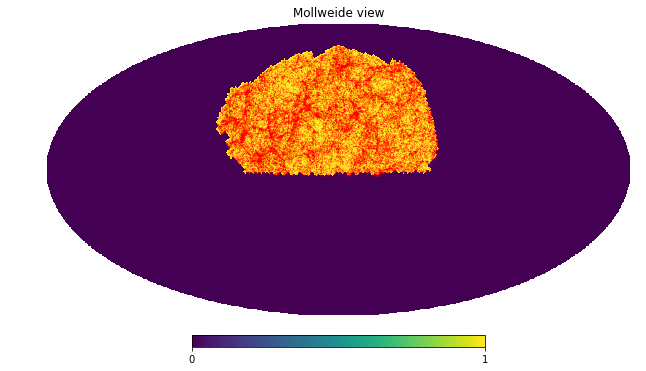

In [5]:
# Estimate area
nside = 36
m = np.zeros(hp.nside2npix(nside))
pixs = hp.ang2pix(nside, np.pi/2-DEC, RA)
pixs = np.unique(pixs)

# Use healpy to cut off the outside pixels
pixs_pop = list()

for p, i in zip(pixs, np.arange(pixs.size)):
    ngbhs = hp.get_all_neighbours(nside, p)
    flag = True
    for ngbh in ngbhs:
        if ngbh == -1:
            continue
        else:
            if not ngbh in pixs:
                flag = False
    if flag == False:
        pixs_pop.append(i)
        
pixs_pop = np.array(pixs_pop)
pixs_pop = np.unique(pixs_pop)

pixs = np.delete(pixs, pixs_pop)

IDS = list()
for r, d, i in zip(RA, DEC, np.arange(RA.size)):
    pix = hp.ang2pix(nside, np.pi/2-d, r)
    if pix in pixs:
        IDS.append(i)
RA = RA[IDS]
DEC = DEC[IDS]
Dist = Dist[IDS]



m[pixs] = 1
pix_area = hp.nside2pixarea(nside, degrees=True)
print(len(pixs_pop)*pix_area)
print(pixs.size*pix_area)
hp.mollview(m, rot=180)
hp.projscatter(np.pi/2-DEC, RA, s=0.01, c='red', alpha=0.75)

In [6]:
N = RA.size
galaxy_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist'),
                          'formats':('float64', 'float64', 'float64')})
galaxy_catalog['ra'] = np.rad2deg(np.ravel(RA))
galaxy_catalog['dec'] = np.rad2deg(np.ravel(DEC))
galaxy_catalog['dist'] = np.ravel(Dist)
np.save('../../Data/sdss_cutoffV2.npy', galaxy_catalog)
pixs_list = np.save("../../Data/gpixs_list.npy", pixs)
